In [1]:
import numpy as np
import sys, os, h5py, re
sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
from learning_utils import prepare_data_flexdmp, calc_loss_flexdmp
from check_dyn import plot_res_6dof

rc_fonts = {
    "text.usetex": True,
    'mathtext.default': 'regular',
    'axes.labelsize': 25,'axes.titlesize':24, 'legend.fontsize': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24
}
mpl.rcParams.update(rc_fonts)

In [2]:
# just for dyna error calc
from casadi_kinodynamics.utils import symbolic_robot
sym_robot = symbolic_robot.symbolic_robot(robot_name='IRB1100_4_058',
                                          tool_mass=4.,
                                          tool_frame=[0., 0., 0.0, 0., 0., 0.],
                                          tool_cog=[0.0, 0., 0.0],
                                          tool_inertia=[
                                              0., 0., 0., 0., 0., 0.],
                                          load_casadi_fnc=True)

In [3]:
from trajencoder.flexdmp.flexdmp import FlexDMP
from algpr.gpr import GaussianProcessRegressor
from algpr.gpoegpr import GpoeGPR
from algpr.kernels import RBF
from algpr.ppgpr import PPGPR
from algpr.vigpr import VIGPR

In [4]:
DMP_ORDER = 50

In [14]:
Xv, Yv, Trueth, qd_trueth, qdd_trueth, tau_trueth = prepare_data_flexdmp("../../data/6dof/new_dynamics/box2box_varOri/Vali_1e-07_jerk_0.00_mass.hdf5", FlexDMP, DMP_ORDER=DMP_ORDER, \
                                                             return_dyddy=True, return_tau=True, dof=6)

In [5]:
from glob import glob
val_list = glob("../../data/6dof/new_dynamics/box2box_varOri/Vali_1e-07_je*")
Xv, Yv, Trueth, qd_trueth, qdd_trueth, tau_trueth = [], [], [], [], [], []
for val_file in val_list:
    Xvi, Yvi, Truethi, qd_truethi, qdd_truethi, tau_truethi = prepare_data_flexdmp(val_file, FlexDMP, DMP_ORDER=DMP_ORDER, \
                                                             return_dyddy=True, return_tau=True, dof=6)
    Xv.append(Xvi)
    Yv.append(Yvi)
    Trueth += Truethi
    qd_trueth+=qd_truethi
    qdd_trueth+=qdd_truethi
    tau_trueth+=tau_truethi
Xv, Yv = np.concatenate(Xv), np.concatenate(Yv)

In [6]:
Yv.shape

(2025, 301)

In [ ]:
# X, Y, _ = prepare_data_flexdmp("../../data/6dof/Training_orient_Box1ToBox2_4.0_mass_al_100.hdf5", \
#                                      FlexDMP, DMP_ORDER=DMP_ORDER, dof=6)

X, Y, _ = prepare_data_flexdmp("/home/jiayun/MotionLearning/suboptimal_planner/data/6dof/Training_1e-07_jerk_0.00_mass.hdf5", \
                                     FlexDMP, DMP_ORDER=DMP_ORDER, dof=6)

In [6]:
from glob import glob
val_list = glob("../../data/6dof/new_dynamics/box2box_varOri/backoff_data/Training_1e-07_jerk*")
X, Y = [], []
for val_file in val_list:
    X_i, Y_i, _ = prepare_data_flexdmp(val_file, FlexDMP, DMP_ORDER=DMP_ORDER, dof=6)
    X.append(X_i)
    Y.append(Y_i)
X, Y = np.concatenate(X), np.concatenate(Y)

In [24]:
X.shape

(36864, 13)

## The evaluation of active learning

In [ ]:
box1 = np.unique(X[:,:6], axis=0)
box2 = np.unique(X[:,6:12], axis=0)
sorted_box1_index_mi = np.array([], dtype=int)
sorted_box2_index_mi = np.array([], dtype=int)
sorted_box1_index_et = np.array([np.random.randint(0,len(box1))], dtype=int)
sorted_box2_index_et = np.array([np.random.randint(0,len(box2))], dtype=int)
kernel = RBF(l=[2]*6, anisotropic=True)
for jj in range(len(box1)-1):
    max_index_box1_mi, _ = PPGPR.max_mulinfo_x_discrete(box1, sorted_box1_index_mi, kernel=kernel)
    max_index_box2_mi, _ = PPGPR.max_mulinfo_x_discrete(box2, sorted_box2_index_mi, kernel=kernel)
    sorted_box1_index_mi = np.concatenate([sorted_box1_index_mi, np.array([max_index_box1_mi])])
    sorted_box2_index_mi = np.concatenate([sorted_box2_index_mi, np.array([max_index_box2_mi])])
    
    if jj < len(box1)-2:
        max_index_box1_et, _ = PPGPR.max_entropy_x_discrete(box1, sorted_box1_index_et, kernel=kernel)
        max_index_box2_et, _ = PPGPR.max_entropy_x_discrete(box2, sorted_box2_index_et, kernel=kernel)
        sorted_box1_index_et = np.concatenate([sorted_box1_index_et, np.array([max_index_box1_et])])
        sorted_box2_index_et = np.concatenate([sorted_box2_index_et, np.array([max_index_box2_et])])

In [ ]:
from itertools import product
time_loss_l_mi = []
peak_vio_l_mi = []
time_loss_l_et = []
peak_vio_l_et = []
for i in range(1,50,3):
    print("Sampling number: ", i)
    
    box1_l_mi = box1[sorted_box1_index_mi[:i]]
    box2_l_mi = box2[sorted_box2_index_mi[:i]]
    box_mix_mi = np.array( list(product(box1_l_mi, box2_l_mi))).reshape(-1,12)
    
    box1_l_et = box1[sorted_box1_index_et[:i]]
    box2_l_et = box2[sorted_box2_index_et[:i]]
    box_mix_et = np.array( list(product(box1_l_et, box2_l_et))).reshape(-1,12)

    index_temp_mi = []
    for x_mix in box_mix_mi:
        index_i = np.all(np.isclose(X[:,:-1], x_mix), axis=1)
        index_temp_mi += np.where(index_i)[0].tolist()
    index_temp_mi = np.array( index_temp_mi)
    Xp_mi, Yp_mi = X[index_temp_mi], Y[index_temp_mi]
    
    index_temp_et = []
    for x_mix in box_mix_et:
        index_i = np.all(np.isclose(X[:,:-1], x_mix), axis=1)
        index_temp_et += np.where(index_i)[0].tolist()
    index_temp_et = np.array( index_temp_et)
    Xp_et, Yp_et = X[index_temp_et], Y[index_temp_et]
    
    gpr_mi = PPGPR(kernel=RBF(l=[1.5]*13, anisotropic=True))
    ind_m = len(Xp_mi) if len(Xp_mi) <= 6500 else 6500
    gpr_mi.fit(Xp_mi, Yp_mi, m=ind_m)
    
    gpr_et = PPGPR(kernel=RBF(l=[1.5]*13, anisotropic=True))
    ind_m = len(Xp_et) if len(Xp_et) <= 6500 else 6500
    gpr_et.fit(Xp_et, Yp_et, m=ind_m)
    print("Start evaluation...")
#######
#     vali_index = np.random.choice(np.arange(len(Xv)), 100)
    Xv_p = Xv
    Yv_p = Yv
    pred_mi = gpr_mi.predict(Xv_p)
    pred_et = gpr_et.predict(Xv_p)
    time_loss, torque_violation, peak_violation, peak_violation_index = calc_loss_flexdmp(pred_mi, Xv_p, Yv_p, DMP_ORDER, dof=6)
    time_loss_mean = time_loss.mean()
    time_loss_max = time_loss.max()
#         print("Time loss mulinfo: ", time_loss_m)
    torque_vio_per = torque_violation/np.array(sym_robot.tau_max) * 100
    torque_vio_peak = np.max(torque_vio_per)
    torque_vio_mean = np.mean(torque_vio_per, axis=0).max()
    print(torque_vio_mean)

    time_loss_l_mi.append([time_loss_max, time_loss_mean])
    peak_vio_l_mi.append([torque_vio_peak, torque_vio_mean])
    
    time_loss, torque_violation, peak_violation, peak_violation_index = calc_loss_flexdmp(pred_et, Xv_p, Yv_p, DMP_ORDER, dof=6)
    time_loss_mean = time_loss.mean()
    time_loss_max = time_loss.max()
#         print("Time loss entropy: ", time_loss_m)
    torque_vio_per = torque_violation/np.array(sym_robot.tau_max) * 100
    torque_vio_peak = np.max(torque_vio_per)
    torque_vio_mean = np.mean(torque_vio_per, axis=0).max()

    time_loss_l_et.append([time_loss_max, time_loss_mean])
    peak_vio_l_et.append([torque_vio_peak, torque_vio_mean])

In [4]:
# time_loss_l_et = np.array(time_loss_l_et)
# peak_vio_l_et = np.array(peak_vio_l_et)

# time_loss_l_mi = np.array(time_loss_l_mi)
# peak_vio_l_mi = np.array(peak_vio_l_mi)
time_loss_l_mi = np.load("time_loss_mi_plot.npy")
peak_vio_l_mi = np.load("peak_vio_mi_plot.npy")
time_loss_l_et = np.load("time_loss_et_plot.npy")
peak_vio_l_et = np.load("peak_vio_et_plot.npy")

np.save("time_loss_mi_plot.npy", time_loss_l_mi)
np.save("peak_vio_mi_plot.npy", peak_vio_l_mi)

np.save("time_loss_et_plot.npy", time_loss_l_et)
np.save("peak_vio_et_plot.npy", peak_vio_l_et)

In [ ]:
peak_vio_l_et.mean(axis=1) < 7.1*1.05
print(range(1,40,2)[5])

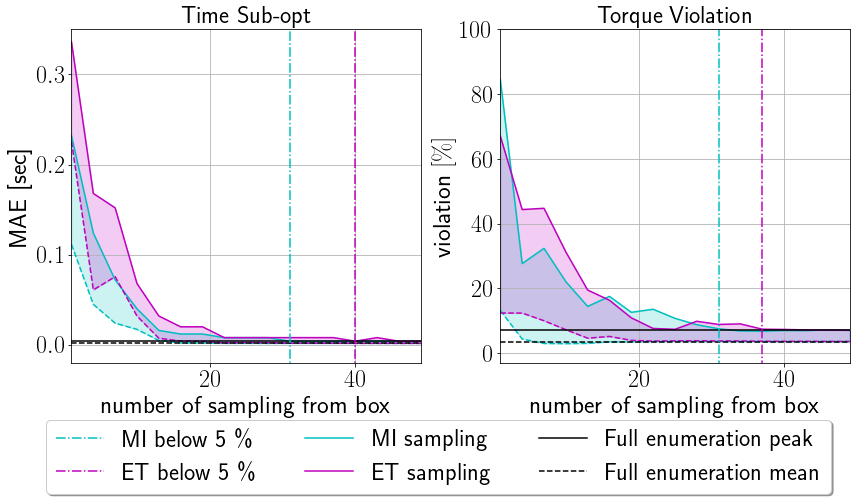

In [7]:
scale_x = range(1,50,3)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(scale_x, time_loss_l_mi[:,0], '-c')
ax1.plot(scale_x, time_loss_l_mi[:,1], '--c')
ax1.fill_between(scale_x, (time_loss_l_mi[:,0]), (time_loss_l_mi[:,1]), color='c', alpha=.2)

ax1.plot(scale_x, time_loss_l_et[:,0], '-m')
ax1.plot(scale_x, time_loss_l_et[:,1], '--m')
ax1.fill_between(scale_x, (time_loss_l_et[:,0]), (time_loss_l_et[:,1]), color='m', alpha=.2)

ax1.plot(scale_x, 0.0017*np.ones_like(scale_x), '--k')
ax1.plot(scale_x, 0.004*np.ones_like(scale_x), '-k')
ax1.plot([31,31], [-10,10], '-.c', label=r"MI below 5 \%")
ax1.plot([40,40], [-10,10], '-.m', label=r"ET below 5 \%")
ax1.set_xlabel("number of sampling from box")
ax1.set_ylabel("MAE [sec]")
ax1.set_xlim([scale_x[0],scale_x[-1]])
ax1.set_ylim([-0.02,0.35])
ax1.grid()
ax1.set_title("Time Sub-opt")
# ax1.legend()

ax2.plot(scale_x, peak_vio_l_mi[:,0], '-c', label="MI sampling")
ax2.plot(scale_x, peak_vio_l_mi[:,1], '--c')
ax2.fill_between(scale_x, (peak_vio_l_mi[:,0]), (peak_vio_l_mi[:,1]), color='c', alpha=.2)

ax2.plot(scale_x, peak_vio_l_et[:,0], '-m', label="ET sampling")
ax2.plot(scale_x, peak_vio_l_et[:,1], '--m')
ax2.fill_between(scale_x, (peak_vio_l_et[:,0]), (peak_vio_l_et[:,1]), color='m', alpha=.2)

ax2.plot(scale_x, 7.1*np.ones_like(scale_x), '-k', label="Full enumeration peak")
ax2.plot(scale_x, 3.5*np.ones_like(scale_x), '--k', label="Full enumeration mean")
# ax2.plot(range(1,40,2), 7.1*np.ones_like(range(1,40,2)), '-r', label="Full enumeration")
ax2.plot([31,31], [-10,400], '-.c')
ax2.plot([37,37], [-10,400], '-.m')
ax2.set_xlabel("number of sampling from box")
ax2.set_ylabel("violation $[\%]$")
ax2.grid()
ax2.set_xlim([scale_x[0],scale_x[-1]])
ax2.set_ylim([-3,100])

ax2.set_title("Torque Violation")

# Put a legend below current axis
lgd = fig.legend(bbox_to_anchor=(0.98, -0.18),loc = 'lower right', fancybox=True, shadow=True, ncol=3)

fig.set_figheight(6)
fig.set_figwidth(12)
plt.tight_layout()
plt.savefig("/home/jiayun/Desktop/ActiveL.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')

## Active learning evaluation end

In [11]:
np.save('X.npy', X)
np.save('Y.npy', Y)

In [10]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [ ]:
from itertools import product
X_all1 = np.load("../../data/6dof/box_oppo/box1_pool.npy")
X_all2 = np.load("../../data/6dof/box_oppo/box2_pool.npy")
index1 = np.random.choice(np.arange(len(X_all1)), 151)
index2 = np.random.choice(np.arange(len(X_all2)), 151)
X_rand = np.array( list( product(X_all1[index1], X_all2[index2]))).reshape(-1,12)
X_rand.shape

In [ ]:
plt.figure(figsize=[11,6])
for i in range(6):
    plt.subplot(int("23{}".format(i+1)))
    plt.plot(X[:,i], X[:,i+6], 'r.', alpha=0.2)
    plt.plot(X_rand[:,i], X_rand[:,i+6],'b.', alpha=0.01)
plt.tight_layout()

## Training

In [ ]:
X = X[:,:12]
Xv = Xv[:,:12]

In [ ]:
full_gpr = GaussianProcessRegressor(kernel=RBF(l=[1.5]*12, anisotropic=True))
full_gpr.fit(X_r, Y_r, call_hyper_opt=True)

In [ ]:
index = np.random.choice(np.arange(0, len(X)), 1000)
X_r, Y_r = X[index], Y[index]

In [ ]:
X = X[:,:12]

In [ ]:
Xv = Xv[:, :12]

In [12]:
gpr = PPGPR(kernel=RBF(l=[1.5]*13, anisotropic=True))
gpr.fit(X, Y, m=7800)
# gpr = PPGPR(kernel=RBF(l=[2.]*13, anisotropic=True) )
# gpr.load_model("../../planner/models/Box1ToBox2_Ker2.npy")

In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
gpr = VIGPR(kernel=RBF(l=np.array([2.]*13), anisotropic=True))
gpr.fit(X, Y, m=100, max_dataset=4000, sub_L=50, cuda=False, Xm_subset_num=2000) # choose one from two points

In [ ]:
pred, full_var = full_gpr.predict(Xv, return_var=True)

In [13]:
pred, pp_var = gpr.predict(Xv, return_var=True)

In [ ]:
pred, vi_var = gpr.predict(Xv, return_var=True)

In [ ]:
### neural networks, bad choice
# import torch
# import torch.nn as nn
# class FlexDMPForcing(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(13, 50),
#             nn.ReLU(),
#             nn.Linear(50, 400),
#             nn.ReLU(),
#             nn.Linear(400, 300),
#             nn.ReLU(),
#             nn.Linear(300, 240),
#             nn.ReLU(),
#             nn.Linear(240, 35*6),
#         )
#         self.init_weights(self.net)
        
#     def forward(self, x):
#         return self.net(x)
    
#     def init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             torch.nn.init.xavier_uniform(m.weight)
#             m.bias.data.fill_(1.)
            
# net = FlexDMPForcing()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# net.load_state_dict(torch.load("../../learning/weight.pth"))
# Xv_ = torch.from_numpy(Xv).float()
# pred_nn = net(Xv_)

# pred[:,:-1] = pred_nn.detach().numpy()
###
### N-D model
import time
time_l = []
for _ in range(10):
    s = time.time()
    kernel = RBF(l=[0.22]*13, anisotropic=True)
    pred = kernel(Xv, X) @ Y / kernel(Xv, X).sum(axis=1).reshape(-1,1)
    e = time.time()
    time_l.append(e-s)
time_l = np.array(time_l)
time_l.mean()

1 . Tuned the DMP3 p and width and Rungkutta 4th integration  
2 . Give it a larger size of AL picked dataset.  
3. Smoother traj. large N of optimization 

In [ ]:
Xv = np.concatenate([Xv, 4*np.ones([400,1])],axis=1)

In [33]:
time_loss, torque_violation, peak_violation, peak_violation_index = calc_loss_flexdmp(pred, Xv, Yv, DMP_ORDER, dof=6, prolong=False)

In [35]:
print("Mean time loss:", time_loss.mean(), "Peak time loss:", time_loss.max())

Mean time loss: 0.01477530864197531 Peak time loss: 0.088


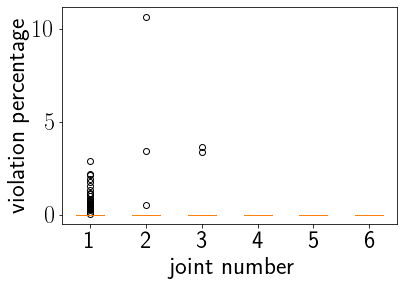

In [36]:
plt.boxplot(torque_violation/np.array(sym_robot.tau_max) * 100)
plt.xlabel("joint number")
plt.ylabel("violation percentage")
plt.savefig("/home/jiayun/Desktop/violation.jpg", dpi=100)
plt.show()

In [37]:
(torque_violation/np.array(sym_robot.tau_max) * 100).max(axis=0).max()

10.631669509022275

In [21]:
peak_violation_index

array([ 573,  802, 2022, 1962,  911,  485])

In [38]:
for joint in range(6):
    percent = 100 * (((torque_violation[:,joint] / sym_robot.tau_max[joint]) * 100) > 5.).sum() / len(Xv)
    print("How many traj of Joint {0} violate the 5 % torque limit: {1:.2f}".format(joint+1 ,percent) )

How many traj of Joint 1 violate the 5 % torque limit: 0.00
How many traj of Joint 2 violate the 5 % torque limit: 0.05
How many traj of Joint 3 violate the 5 % torque limit: 0.00
How many traj of Joint 4 violate the 5 % torque limit: 0.00
How many traj of Joint 5 violate the 5 % torque limit: 0.00
How many traj of Joint 6 violate the 5 % torque limit: 0.00


In [ ]:
gpr.save_model("Box1ToBox2_fixedOri_variable_payload_kernel_(1.5*13)")

Random sample  
The rate of dyna violation:  100.0 %  
The peak dyna violation:  [ 6.21185348 10.55968748  0.          3.71654357  0.          1.28119113]  
Peak dyna violation occurs at:  [186. 193.   0.  33.   0. 202.]  
The peak vel non-zero:  [0.22423251 0.05240221 0.0971503  0.14482993 0.11228568 0.22102077]  
0.002097777777777778 0.0673332432911947 0.24270222069696104

Kernel Regression:  
The rate of dyna violation:  95.11111111111111 %  
The peak dyna violation:  [12.21483055  4.39031308  0.85363343  0.          0.          0.3339995 ]  
Peak dyna violation occurs at:  [151.  10.  21.   0.   0. 151.]  
The peak vel non-zero:  [0.22535581 0.12319966 0.15815734 0.00487762 0.12210554 0.19267326]  
0.0022044444444444446 0.011865373315657896 0.22092989636195373  


sparse-GP:  
The rate of dyna violation:  99.11111111111111 %  
The peak dyna violation:  [4.89236314 3.63130148 1.25203258 0.         0.         0.24210191]  
Peak dyna violation occurs at:  [155. 163.  21.   0.   0. 149.]  
The peak vel non-zero:  [0.20415126 0.08580309 0.12413602 0.00325246 0.07068176 0.18778735]  
0.0017244444444444455 0.008600736551722719 0.2230232570878485

sparse-GP-time + nn-DMP:  
The rate of dyna violation:  99.55555555555556 %  
The peak dyna violation:  [6.42262095 3.90635188 1.66475741 0.         0.         0.23731786]  
Peak dyna violation occurs at:  [156. 149.  21.   0.   0. 183.]  
The peak vel non-zero:  [0.21346654 0.09944592 0.09868367 0.02733289 0.06707143 0.19303345]  
0.0017244444444444455 0.008875566678227028 0.23328338645800245

In [39]:
diff = np.abs(pred[:,-1] - Yv[:,-1])
100 * (diff).sum() / Yv[:,-1].sum()

4.153740546622158

In [42]:
np.max(100 * (diff) * (61/88) / Yv[:,-1])

21.94860546200388

In [23]:
from learning_utils import spline_reconstruct_via, flexdmp_reconstruct
rc_fonts = {
    "text.usetex": True,
    'mathtext.default': 'regular',
    'axes.labelsize': 23,'axes.titlesize':14, 'legend.fontsize': 20, 'xtick.labelsize': 22, 'ytick.labelsize': 22
}
font_size = 26
mpl.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
def get_traj_tau(tau_func, q, dq, ddq):
    tau = []
    for i in range(len(q)):
        tau_i = tau_func(q[i,:],dq[i,:],ddq[i,:]).full()
        tau.append(tau_i.reshape(1,-1))
    return np.concatenate(tau)
def plot_res_6dof(q_max, q_min, dq_max, ddq_max, index, pred, Xv, Yv, Trueth, dq_trueth, ddq_trueth, tau_trueth, dmp3=None, DMP_ORDER=None, dof=6, dt=0.004):
    plt.figure(figsize=[10,18])
    color_map = {0:'brown', 1:'orange', 2:'dimgray', 3:'green', 4:'c', 5:'blue'}
    # figure 1
    plt.subplot(411)

    q_real = Trueth[index]
    PARAM = pred[index,0:-1].reshape(dof, DMP_ORDER)
    length = int(pred[index, -1])
    initial, goal = q_real[0], q_real[-1]
    q, dq, ddq = flexdmp_reconstruct(PARAM, initial, goal, length, DMP_ORDER, dof)
    t = np.linspace(0, len(q)*dt, len(q))
    
    # plt.plot([t[-1], t[-1]], [np.min(Trueth[index]), np.max(Trueth[index])], '-.b') # the indicator line for the ending of prediction
    time_vec = np.linspace(0, Yv[index,-1]*dt, int(Yv[index,-1])) # time vector of the ground trueth
    # plt.plot([time_vec[-1], time_vec[-1]], [np.min(Trueth[index]), np.max(Trueth[index])], '-.r')
    plt.ylabel(r"$\mathbf{q}\ [rad]$", fontsize=font_size)
    for i in range(dof):
        plt.plot(t, q[:,i], '-', color=color_map[i], label='Joint {}'.format(i+1))
        plt.plot(time_vec, Trueth[index][:,i], '--', color=color_map[i])
        # plt.plot(t, np.ones_like(t)*q_max[i], '-.', color=color_map[i], alpha=0.4)
        # plt.plot(t, np.ones_like(t)*q_min[i], '-.', color=color_map[i], alpha=0.4)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    # plt.xlabel("time [sec]",fontsize=font_size)
    handles = [handles[i] for i in ids]
    plt.grid()
    
    # figure 2, plot the velocity
    plt.subplot(412)
    for i in range(dof):
        plt.plot(t, dq[:,i], '-', color=color_map[i])
        plt.plot(time_vec, dq_trueth[index][:,i], '--', color=color_map[i])
        plt.plot(t, np.ones_like(t)*dq_max[i], '-.', color=color_map[i], alpha=0.4)
        plt.plot(t, -np.ones_like(t)*dq_max[i], '-.', color=color_map[i], alpha=0.4)
    plt.grid()
    dq_max_line = np.max([np.max(dq_trueth[index]), np.max(dq)])
    dq_min_line = np.min([np.min(dq_trueth[index]), np.min(dq)])
    
    plt.ylim(dq_max_line+1., dq_min_line-1.)
    plt.ylabel(r"$\dot{\mathbf{q}}\ [rad/s]$", fontsize=font_size)
    # plt.xlabel("time [sec]",fontsize=font_size)
    # figure 3, plot the acceleration
    plt.subplot(413)
    for i in range(dof):
        plt.plot(t, ddq[:,i], '-', color=color_map[i])
        plt.plot(time_vec, ddq_trueth[index][:,i], '--', color=color_map[i])
        plt.plot(t, np.ones_like(t)*ddq_max[i], '-.', color=color_map[i], alpha=0.4)
        plt.plot(t, -np.ones_like(t)*ddq_max[i], '-.', color=color_map[i], alpha=0.4)
    plt.grid()
    plt.ylabel(r"$\ddot{\mathbf{q}}\ [rad/s^2]$", fontsize=font_size)
    # plt.xlabel("time [sec]",fontsize=font_size)
    # figure 4, plot the dynamics
    plt.subplot(414)
    sym_robot = symbolic_robot.symbolic_robot(robot_name='IRB1100_4_058',
                                          tool_mass=Xv[index, -1],
                                          tool_frame=[0., 0., 0.0, 0., 0., 0.],
                                          tool_cog=[0.0, 0., 0.0],
                                          tool_inertia=[
                                              0., 0., 0., 0., 0., 0.],
                                          load_casadi_fnc=True)
    tau_func = sym_robot.inv_dyn
    tau_max = sym_robot.tau_max
    tau = get_traj_tau(tau_func, q, dq, ddq)
    for i in range(dof):
        plt.plot(t, 100* tau[:,i] / tau_max[i], '-', color=color_map[i])
        plt.plot(time_vec, 100* tau_trueth[index][:,i] / tau_max[i], '--', color=color_map[i])
    plt.plot(t, 100*np.ones_like(tau), '-.', color='red', alpha=0.4)
    plt.plot(t, -np.ones_like(tau)*100, '-.', color='red', alpha=0.4)
    plt.grid()
    legend1 = plt.legend(handles, labels, loc='best', ncol=5, bbox_to_anchor=(1.015,4.95), labelspacing=0.1, columnspacing=.4)
    plt.plot([], [], '--k', label="Optimal")
    plt.plot([], [], '-k', label="Prediction")
    plt.plot([], [], '-.k', label="Constraints")
    plt.legend(loc='best', ncol=3, bbox_to_anchor=(1.014,4.82), labelspacing=0.1, columnspacing=.5, framealpha=1)
    plt.gca().add_artist(legend1)
    plt.xlabel("time [sec]",fontsize=font_size)
    plt.ylabel(r"\boldmath$\tau$ utilization $[\%]$", fontsize=font_size)

    plt.savefig(r'/home/jiayun/MotionLearning/suboptimal_planner/plots/ordinary/{}_dmp_baseline.svg'.format(index), dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
for i in range(1893,1900):#peak_violation_index:
    plot_res_6dof(sym_robot.q_max, sym_robot.q_min, sym_robot.qd_max, sym_robot.qdd_max, i, pred, Xv, Yv, Trueth,\
                  qd_trueth, qdd_trueth, tau_trueth, dmp3=FlexDMP, DMP_ORDER=DMP_ORDER)